# Metric visualisation from stored metric data

Import libraries

In [1]:
from hoi.metrics import InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

Define functions

In [53]:
# --- Visualization Functions ---
def configure_plot_fonts(base_size=20):
    plt.rcParams.update({
        'font.size': base_size + 2,
        'axes.titlesize': base_size + 4,
        'axes.labelsize': base_size + 2,
        'xtick.labelsize': base_size,
        'ytick.labelsize': base_size,
        'legend.fontsize': base_size
    })

def normalize_signed(values):
    values = np.array(values)
    normalized = np.zeros_like(values, dtype=float)

    # Normalize positive values between 0 and 1
    if np.any(values > 0):
        pos_mask = values > 0
        max_pos = np.max(values[pos_mask])
        if max_pos != 0:
            normalized[pos_mask] = values[pos_mask] / max_pos

    # Normalize negative values between -1 and 0
    if np.any(values < 0):
        neg_mask = values < 0
        min_neg = np.min(values[neg_mask])
        if min_neg != 0:
            normalized[neg_mask] = values[neg_mask] / abs(min_neg)

    return normalized

def plot_metric_results(metrics_data, averages_data, metrics_classes):
    """Visualize line plots and heatmaps for each metric."""
    num_metrics = len(metrics_classes)
    fig, axs = plt.subplots(2, num_metrics, figsize=(6 * num_metrics, 10), sharey='row')
    axs = np.array(axs).reshape(2, num_metrics)

    for i, (top_ax, bottom_ax, metric_cls) in enumerate(zip(axs[0], axs[1], metrics_classes)):
        # Determine the name of the metric to access the dictionary
        metric_name = metric_cls if isinstance(metric_cls, str) else metric_cls.__name__

        data, labels, label_pos = metrics_data[metric_name]
        sim_avg = averages_data[metric_name]
        *individual_avgs, avg_all = sim_avg
        timesteps = range(1, len(avg_all) + 1)

        # Line plot (top row)
        for avg in individual_avgs:
            norm_avg = normalize_signed(avg)
            top_ax.plot(timesteps, norm_avg, color='gray', linestyle='--', marker='o', alpha=0.7)

        norm_avg_all = normalize_signed(avg_all)
        for j in range(len(timesteps) - 1):
            y0, y1 = norm_avg_all[j], norm_avg_all[j + 1]
            x0, x1 = timesteps[j], timesteps[j + 1]

            if y0 >= 0 and y1 >= 0:
                color = 'red'
            elif y0 <= 0 and y1 <= 0:
                color = 'blue'
            else:
                color = 'gray'

            top_ax.plot([x0, x1], [y0, y1], color=color, linewidth=2)
            top_ax.plot(x0, y0, 'o', color=color)
        top_ax.plot(timesteps[-1], norm_avg_all[-1], 'o', color='red' if norm_avg_all[-1] >= 0 else 'blue')
        top_ax.set_title(metric_name)
        top_ax.set_ylim(-1, 1)
        top_ax.set_xticklabels([])
        if i == 0:
            top_ax.set_ylabel("Average Value")
        top_ax.grid(True)

        # Heatmap (bottom row)
        cax = bottom_ax.imshow(data.T, aspect='auto', cmap='viridis', origin='lower')
        bottom_ax.set_xlabel("Time")
        bottom_ax.set_xticks(range(data.shape[0]))
        bottom_ax.set_xticklabels(range(data.shape[0]))
        if i == 0:
            bottom_ax.set_ylabel("Order")
            bottom_ax.set_yticks(list(label_pos.values()))
            bottom_ax.set_yticklabels(labels)

    plt.tight_layout(h_pad=0.1)
    plt.show()

def main(data_dir, metrics_classes):
    heatmap_path = os.path.join(data_dir, "heatmap_data.pkl")
    averages_path = os.path.join(data_dir, "averages_data.pkl")

    with open(heatmap_path, "rb") as f:
        heatmap_data = pickle.load(f)
    with open(averages_path, "rb") as f:
        averages_data = pickle.load(f)

    configure_plot_fonts()
    plot_metric_results(heatmap_data, averages_data, metrics_classes)

Visualise metric results for the desired dataset

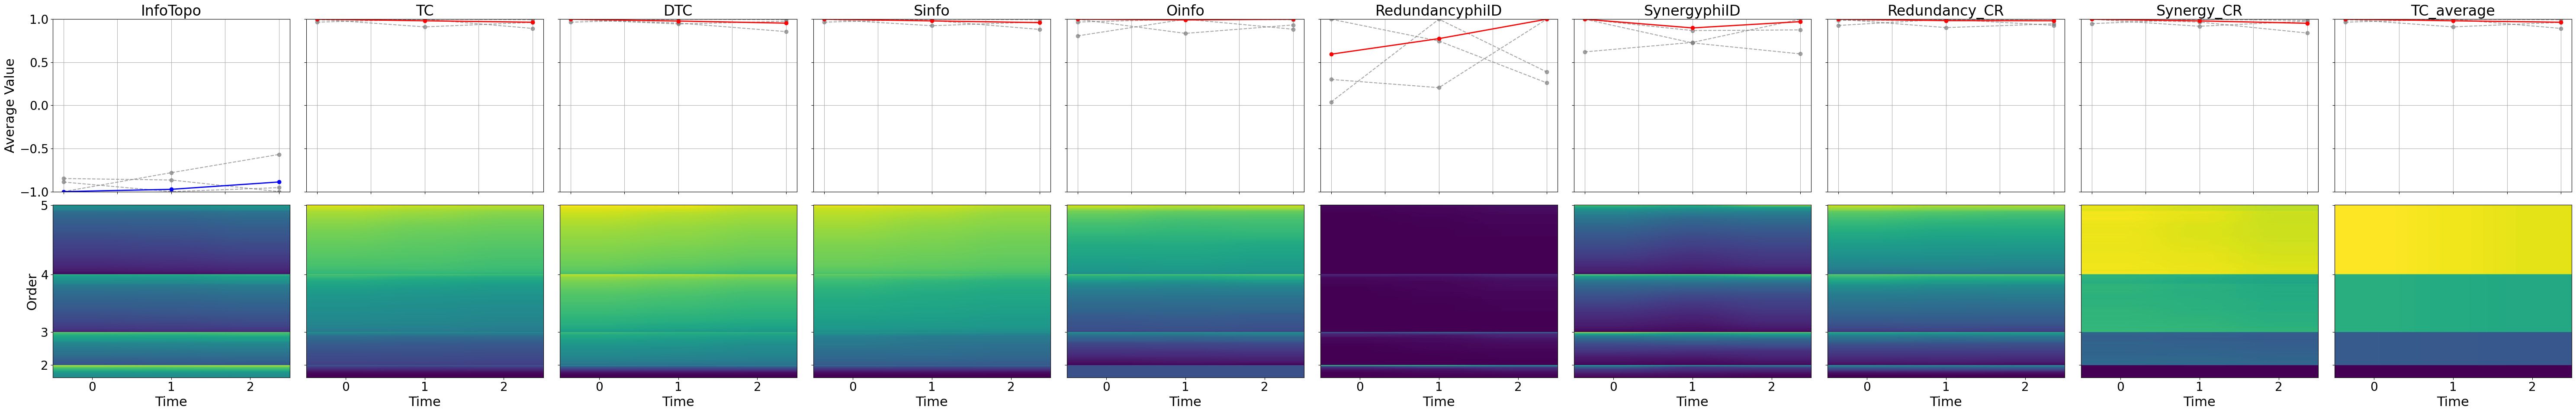

In [74]:
# Choose desired dataset
data_directory = r'Data\Artificial_data\Synergistic_timeseries'

# Retrieve complete list of metrics or specify desired one
averages_path = os.path.join(data_directory, "averages_data.pkl")
with open(averages_path, "rb") as f:
    averages_data = pickle.load(f)
metrics = list(averages_data.keys()) # Adjust to specify desired metrics, e.g. metrics = ['InfoTopo', 'TC', 'Oinfo']

# Run main code to visualise
main(data_directory, metrics)